# Final Project - Korean to English Translation

- Sequence to Sequence 모델의 대표적인 한국어-영어 번역을 Encoder-decoder, Attention, Convolution, 그리고 Transformers 기반으로 구현
- 수업시간에 살펴본 Pytorch Seq to Seq 모델 (https://github.com/bentrevett/pytorch-seq2seq)을 참조로 하여 한국어와 영어 형태소분석되고 의존관계로 되어 있는 파일을 프로세싱하여 두 언어의 parallel 데이터 쌍으로 만들고 이를 학습하여 모델별로 Perplexity가 어떻게 달라지는지 살펴 보고, 가장 성능이 좋은 모델을 근간으로 해서 Inference로 한국어 문장을 입력하면 대응되는 영어 번역이 출력될 수 있도록 구현
- 반드시 다음 세 모델에 대해서 PPL와 BLEU score가  다 체크되어야 함. (Packed) Encoder-Decoder, Convolutional Seq to Seq, Transformers ...
- 세 모델 중에 학습이 제대로 이루어지지 않는 경우, PPL이나 BLEU가 문제가 있는 경우 이를 Fix하려고 시도해 보라.
- Inference시에 unk인 단어를 로마자화해서 번역에 나타날 수 있도록 시도해 볼 것(참고할 수 있는 사이트 중 하나 https://github.com/osori/korean-romanizer)

- 개인적으로 하거나 최대 두명까지 그룹 허용. 
- 이 노트북 화일에 이름을 변경하여 작업하고 제출. 제출시 화일명을 Assignment4_[DS또는 CL]_학과_이름.ipynb

## Data 1
- 첨부된 ko-en-en.parse.syn은 330,974 한국어 문장에 대응되는 영어문장이 품사와 구문분석이 되어 있는 파일이고 ko-en-ko.parse.syn은 이에 대응되는 한국어 문장이 형태소와 구문분석이 되어 있는 파일이다.

(ROOT (S (NP (NNP Flight) (NNP 007)) (VP (MD will) (VP (VB stay) (PP (IN on) (NP (NP (DT the) (NN ground)) (PP (IN for) (NP (CD one) (NN hour))))))) (. .)))


<id 1>
<sent 1>
1       2       NP      777/SN
2       6       NP_SBJ  항공편/NNG|은/JX
3       4       NP      1/SN|시간/NNG
4       6       NP_AJT  동안/NNG
5       6       NP_AJT  지상/NNG|에/JKB
6       7       VP      머물/VV|게/EC
7       0       VP      되/VV|ㅂ니다/EF|./SF
</sent>
</id>

    - 이 두 파일을 프로세싱하여 한-영 병렬 데이터로 만들고 이를 학습 및 테스트 데이터로 사용한다.
    - Hint: 구조화된 데이터를 프로세싱하기 위해서는 nltk의 모듈을 사용할 수 있다.

    - 한국어 형태소 분석된 단위를 어절별로 결합할 수 있고, 분석된 채로 그대로 사용할 수도 있다.
    - 두 언어의 어순을 비슷하게 데이터를 만들어 학습할 수도 있고, 번역의 성능을 높이기 위해 다양한 형태로 재구조화 할 수 있다.

## Data 2
[Korean Parallel Corpora](https://github.com/jungyeul/korean-parallel-corpora)에는 Korean-English-jhe, Korean-English-news-v1의 병렬 데이터가 있다. 
- 이 데이터를 다운 받아 Data1의 자료와 합쳐서 사용할 수 있다
- 이 경우 형태소 분석이 된 경우와 그렇지 않은 자료가 있으니, Data1의 자료와 합칠 때 형태소 분석을 하거나 아니면 어절 단위로 결합하여 할 수도 있다.
- 전체적인 일관성 및 inference를 위해서 형태소 분석된 것이 더 좋을 수 있는데, 이 경우 형태소 분석되지 않는 데이터는 새로 형태소 분석을 할 필요. 단 형태소 분석 단위가 일치하는지 알아볼 필요. 형태소 분석 단위가 완전히 일치하지 않는다면 가급적 분석단위 일치도가 높은 형태소 분석기를 선택할 필요

## 구현,실험 전체적인 설명 및 분석 

## Your Code

In [1]:
from tqdm import tqdm
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.vocab import Vectors
from torchtext.legacy import data
from torchtext.legacy import datasets

import json # save parsed list
import gensim #!# I used gensim==3.8.1 instead of latest version, since it has some error
from nltk import Tree

import random
import numpy as np

# for drawing
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm  # 폰트 관련 용도
import warnings
warnings.filterwarnings('ignore')


from sys import platform
if 'linux' == platform:
  print('Jeehun Operating code')
  from google.colab import drive ; drive.mount('/content/drive') # Colab setting
  !pip install einops # Colab setting

  # matplotlib
  !sudo apt-get install -y fonts-nanum
  !sudo fc-cache -fv
  !rm ~/.cache/matplotlib -rf

  os.chdir('/content/drive/MyDrive/[NLP2021] Ass4')


# fm._rebuild() # font reset
mpl.rcParams['axes.unicode_minus'] = False
from einops import rearrange, reduce

Jeehun Operating code
Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (44.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-

In [2]:
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

sys_font number: 27
nanum_font number: 10


In [3]:
nanum_font

['/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf']

In [4]:
import matplotlib.pyplot as plt

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

NanumBarunGothic


In [5]:
!nvidia-smi

Sun Nov 21 13:40:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## preprocessing

In [6]:
with open('ko-en.ko.parse','r') as f:
    ko = list(f)

## split 으로 구분할 수 있는 형태로 전처리
# 문장 단위로 분리하기
# 문장 내부에서 token 추출하기

def extract_sentence(token_list):
    '''extract <sent #> sth </sent>'''
    sentence_list = []
    sentence = ''
    in_sentence = False

    for tok in token_list:
        if '<id' in tok:
            in_sentence = True

        if in_sentence:
            sentence += tok

        if '</id>' in tok:
            sentence_list.append(sentence)
            in_sentence = False
            sentence = ''
            
    return sentence_list

def extract_token(segment_with_morpheme) -> list:
    '''split token/morpheme|...|token/morpheme'''
    '''since we tokenize the data before import on torchtext, convert every string object to lowercase'''
    token_list = []
    if '|' in segment_with_morpheme: # multiple token in a sement
        for token in segment_with_morpheme.split(sep = '|'):
            token_list.append(str.lower(token.split(sep = '/')[0]))
        
    else: # multiple token in a sement
        token_list.append(str.lower(segment_with_morpheme.split(sep = '/')[0]))
        
    return token_list

def preprocess(ko):
    processed_sentence_list = []
    sentence_list = extract_sentence(ko)
    
    for sentence in tqdm(sentence_list):
        processed_token_list = []
        for segment in sentence.split(sep = '\n'):
            if '\t' in segment:
                token_with_morpheme = segment.split(sep = '\t')[-1]
                processed_token_list += extract_token(token_with_morpheme)
                
        processed_token_list.insert(0, '<sos>')
        processed_token_list.append('<eos>')
        processed_sentence_list.append(processed_token_list)

    return processed_sentence_list

processed_ko = preprocess(ko)

100%|██████████| 330974/330974 [00:04<00:00, 66329.64it/s]


In [7]:
# English data
with open('ko-en.en.parse.syn') as f:
    en = f.readlines()

processed_en = []
for idx, _ in tqdm(enumerate(en)):
    t = Tree.fromstring(en[idx])
    processed_token_list = [str.lower(token) for token in t.leaves()]
    
    processed_token_list.insert(0, '<sos>')
    processed_token_list.append('<eos>')
    
    processed_en.append(processed_token_list)

330974it [00:25, 13189.41it/s]


In [8]:
## torchtext 에 전달하기
# save parsed dataset as a json file
split_idx = len(processed_ko) // 10

ko_en_json_train = [{'ko' : ko, 'en' : en} for ko, en in zip(processed_ko[:split_idx*8], processed_en[:split_idx*8])] #!# change it after practice
ko_en_json_valid = [{'ko' : ko, 'en' : en} for ko, en in zip(processed_ko[split_idx*8:split_idx*9], processed_en[split_idx*8:split_idx*9])] #!# change it after practice
ko_en_json_test  = [{'ko' : ko, 'en' : en} for ko, en in zip(processed_ko[split_idx*9:], processed_en[split_idx*9:])] #!# change it after practice

ko_en_json_small = [{'ko' : ko, 'en' : en} for ko, en in zip(processed_ko[:256*8], processed_en[:256*8])] #!# for debug

In [9]:
with open("ko_en_parsed_train.json" , encoding= "utf-8", mode="w") as file: 
    for i in ko_en_json_train: file.write(json.dumps(i) + "\n")
        
with open("ko_en_parsed_valid.json" , encoding= "utf-8", mode="w") as file: 
    for i in ko_en_json_valid: file.write(json.dumps(i) + "\n")
        
with open("ko_en_parsed_test.json" , encoding= "utf-8", mode="w") as file: 
    for i in ko_en_json_test: file.write(json.dumps(i) + "\n")

  
with open("ko_en_parsed_small.json" , encoding= "utf-8", mode="w") as file: 
    for i in ko_en_json_test: file.write(json.dumps(i) + "\n")

In [ ]:
## pack padded seq2seq
# torchtext iterator 만들어주기
KOREAN = data.Field( 
    init_token = '<sos>', 
    eos_token = '<eos>', 
    include_lengths = True
)

ENGLISH = data.Field( 
    init_token = '<sos>', 
    eos_token = '<eos>'
)

fields  = {'ko' : ('ko', KOREAN), 'en' : ('en', ENGLISH)}

train_data, valid_data, test_data = data.TabularDataset.splits(
                            path  = os.getcwd(), #!#
                            # train = "ko_en_parsed_small.json", #!# 'ko_en_parsed_train.json'
                            # test  = "ko_en_parsed_small.json", #!# 'ko_en_parsed_test.json'

                            train = "ko_en_parsed_train.json", 
                            validation = "ko_en_parsed_valid.json", 
                            test  = "ko_en_parsed_test.json",
                            format = 'json',
                            fields = fields
)

print(vars(train_data.examples[63])['en'])
print(vars(train_data.examples[63])['ko'])

BATCH_SIZE = 128 #!# hyper parameter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
     (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.ko),
     device = device)

KOREAN.build_vocab(train_data, max_size=10000, min_freq=2) # Word2Vec 모델을 임베딩 벡터값으로 초기화

ENGLISH.build_vocab(train_data, max_size=10000, min_freq=2) # Word2Vec 모델을 임베딩 벡터값으로 초기화

['<sos>', '10', 'minutes', '.', 'never', 'mind', '.', '<eos>']
['<sos>', '10', '분', '이', 'ㅂ니다', '.', '신경', '쓰', '지', '말', '시', '어요', '.', '<eos>']


In [10]:
## Conv. seq2seq, Transfomer seq2seq
# torchtext iterator 만들어주기
CNN_KOREAN = data.Field( 
#     sequential = False, #!#
    init_token = '<sos>', 
    eos_token = '<eos>', 
    batch_first = True,
    include_lengths = False #!#
)

CNN_ENGLISH = data.Field( 
    init_token = '<sos>', 
    eos_token = '<eos>', 
    batch_first = True
)

CNN_fields  = {'ko' : ('ko', CNN_KOREAN), 'en' : ('en', CNN_ENGLISH)}

train_data, valid_data, test_data = data.TabularDataset.splits(
                            path  = os.getcwd(), #!#
                            # train = "ko_en_parsed_small.json", #!# 'ko_en_parsed_train.json'
                            # test  = "ko_en_parsed_small.json", #!# 'ko_en_parsed_test.json'

                            train = "ko_en_parsed_train.json", #!# 'ko_en_parsed_train.json'
                            validation = "ko_en_parsed_valid.json",
                            test  = "ko_en_parsed_test.json", #!# 'ko_en_parsed_test.json'
                            format = 'json',
                            fields = CNN_fields
)

print(vars(train_data.examples[63])['en'])
print(vars(test_data.examples[63])['ko'])

BATCH_SIZE = 128 #!# hyper parameter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CNN_train_iterator,CNN_valid_iterator, CNN_test_iterator = data.BucketIterator.splits(
     (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.ko),
     device = device)

CNN_KOREAN.build_vocab(train_data, max_size=10000, min_freq=2) # Word2Vec 모델을 임베딩 벡터값으로 초기화

CNN_ENGLISH.build_vocab(train_data, max_size=10000, min_freq=2) # Word2Vec 모델을 임베딩 벡터값으로 초기화

['<sos>', '10', 'minutes', '.', 'never', 'mind', '.', '<eos>']
['<sos>', '와우', '!', '고맙', '어', '.', '<eos>']


## model

In [11]:
## model building
# preparation
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device

device(type='cuda')

### \<pack padded\> seq2seq

In [ ]:
## model 1 : (Packed) Encoder-Decoder
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

### 2. CNN

In [12]:
## model 2 : Convolutional Seq to Seq
class Conv_Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        #create position tensor
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [0, 1, 2, 3, ..., src len - 1]
        
        #pos = [batch size, src len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = pos_embedded = [batch size, src len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, src len, emb dim]
        
        #pass embedded through linear layer to convert from emb dim to hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, src len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, src len]
        
        #begin convolutional blocks...
        
        for i, conv in enumerate(self.convs):
        
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))

            #conved = [batch size, 2 * hid dim, src len]

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale

            #conved = [batch size, hid dim, src len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
        
        #...end convolutional blocks
        
        #permute and convert back to emb dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
        
        #conved = [batch size, src len, emb dim]
        
        #elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale
        
        #combined = [batch size, src len, emb dim]
        
        return conved, combined

class Conv_Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 trg_pad_idx, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        
        #embedded = [batch size, trg len, emb dim]
        #conved = [batch size, hid dim, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        
        #permute and convert back to emb dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        
        #conved_emb = [batch size, trg len, emb dim]
        
        combined = (conved_emb + embedded) * self.scale
        
        #combined = [batch size, trg len, emb dim]
                
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        
        #energy = [batch size, trg len, src len]
        
        attention = F.softmax(energy, dim=2)
        
        #attention = [batch size, trg len, src len]
            
        attended_encoding = torch.matmul(attention, encoder_combined)
        
        #attended_encoding = [batch size, trg len, emd dim]
        
        #convert from emb dim -> hid dim
        attended_encoding = self.attn_emb2hid(attended_encoding)
        
        #attended_encoding = [batch size, trg len, hid dim]
        
        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        
        #attended_combined = [batch size, hid dim, trg len]
        
        return attention, attended_combined
        
    def forward(self, trg, encoder_conved, encoder_combined):
        
        #trg = [batch size, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
            
        #create position tensor
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, trg len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = [batch size, trg len, emb dim]
        #pos_embedded = [batch size, trg len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, trg len, emb dim]
        
        #pass embedded through linear layer to go through emb dim -> hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, trg len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, trg len]
        
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
        
            #apply dropout
            conv_input = self.dropout(conv_input)
        
            #need to pad so decoder can't "cheat"
            padding = torch.zeros(batch_size, 
                                  hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
                
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
        
            #padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
        
            #pass through convolutional layer
            conved = conv(padded_conv_input)

            #conved = [batch size, 2 * hid dim, trg len]
            
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, trg len]
            
            #calculate attention
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
            
            #attention = [batch size, trg len, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            
            #conved = [batch size, hid dim, trg len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
         
        #conved = [batch size, trg len, emb dim]
            
        output = self.fc_out(self.dropout(conved))
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

class Conv_Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
           
        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
        #  positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src)
            
        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]
        
        #calculate predictions of next words
        #output is a batch of predictions for each word in the trg sentence
        #attention a batch of attention scores across the src sentence for 
        #  each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        
        return output, attention

### 3. Transformer

In [13]:
## model 3 : Transformers
class Transformer_Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x
class Transformer_Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention
    
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention
    
class Transformer_Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention


## training

In [ ]:
## training
# model 1 : pack padded seq2seq
INPUT_DIM   = len(KOREAN.vocab)  #!# same for-pretrained vocab?
OUTPUT_DIM  = len(ENGLISH.vocab) #!# same for-pretrained vocab?
ENC_EMB_DIM = 256 #!# 300
DEC_EMB_DIM = 256 #!# 300
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
KO_PAD_IDX = KOREAN.vocab.stoi[KOREAN.pad_token]
EN_PAD_IDX = ENGLISH.vocab.stoi[ENGLISH.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc  = Encoder(INPUT_DIM,  ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec  = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

Seq2Seq_model = Seq2Seq(enc, dec, KO_PAD_IDX, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
Seq2Seq_model.apply(init_weights)

optimizer = optim.Adam(Seq2Seq_model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = EN_PAD_IDX)

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        ko, ko_len = batch.ko
        en = batch.en
        
        optimizer.zero_grad()
        
        output = model(ko, ko_len, en)
        
        #en = [en len, batch size]
        #output = [en len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        en = en[1:].view(-1)
        
        #en = [(en len - 1) * batch size]
        #output = [(en len - 1) * batch size, output dim]
        
        loss = criterion(output, en)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            ko, ko_len = batch.ko
            en = batch.en

            output = model(ko, ko_len, en, 0) #turn off teacher forcing
            
            #en = [en len, batch size]
            #output = [en len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            en = en[1:].view(-1)

            #en = [(en len - 1) * batch size]
            #output = [(en len - 1) * batch size, output dim]

            loss = criterion(output, en)

            epoch_loss += loss.item() # '+= loss' 에 비해서 메모리를 아껴주는 방법
        
    return epoch_loss / len(iterator)

In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530/29
# https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html # cuda.cpu()

In [ ]:
# model 1 : pack padded seq2seq
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    torch.cuda.empty_cache() # to release cache memory 

    start_time = time.time()
    
    train_loss = train(Seq2Seq_model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(Seq2Seq_model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(Seq2Seq_model.state_dict(), 'Seq2Seq_model.pt')
    # else: # for memory

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')


Epoch: 01 | Time: 6m 9s
	Train Loss: 2.840 | Train PPL:  17.117
	 Val. Loss: 3.104 |  Val. PPL:  22.296
Epoch: 02 | Time: 6m 10s
	Train Loss: 1.814 | Train PPL:   6.133
	 Val. Loss: 2.700 |  Val. PPL:  14.881
Epoch: 03 | Time: 6m 10s
	Train Loss: 1.536 | Train PPL:   4.648
	 Val. Loss: 2.515 |  Val. PPL:  12.368
Epoch: 04 | Time: 6m 9s
	Train Loss: 1.384 | Train PPL:   3.992
	 Val. Loss: 2.394 |  Val. PPL:  10.953
Epoch: 05 | Time: 6m 9s
	Train Loss: 1.289 | Train PPL:   3.629
	 Val. Loss: 2.302 |  Val. PPL:   9.995
Epoch: 06 | Time: 6m 10s
	Train Loss: 1.225 | Train PPL:   3.404
	 Val. Loss: 2.241 |  Val. PPL:   9.401
Epoch: 07 | Time: 6m 9s
	Train Loss: 1.173 | Train PPL:   3.231
	 Val. Loss: 2.146 |  Val. PPL:   8.548
Epoch: 08 | Time: 6m 9s
	Train Loss: 1.143 | Train PPL:   3.136
	 Val. Loss: 2.083 |  Val. PPL:   8.030
Epoch: 09 | Time: 6m 9s
	Train Loss: 1.108 | Train PPL:   3.029
	 Val. Loss: 2.039 |  Val. PPL:   7.681
Epoch: 10 | Time: 6m 9s
	Train Loss: 1.071 | Train PPL:   2.9

In [15]:
# model 2 : Conv. seq2seq
#!# batch-first 에 주의할 것
INPUT_DIM  = len(CNN_KOREAN.vocab)
OUTPUT_DIM = len(CNN_ENGLISH.vocab)
EMB_DIM = 256 #!# 300
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
EN_PAD_IDX = CNN_ENGLISH.vocab.stoi[CNN_ENGLISH.pad_token]
    
enc = Conv_Encoder(INPUT_DIM,  EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Conv_Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, EN_PAD_IDX, device)

CNN_model = Conv_Seq2Seq(enc, dec).to(device)

optimizer = optim.Adam(CNN_model.parameters())

criterion = nn.CrossEntropyLoss(ignore_index = EN_PAD_IDX)

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        ko = batch.ko
        en = batch.en
        
        optimizer.zero_grad()
        
        output, _ = model(ko, en[:,:-1])
        
        #output = [batch size, en len - 1, output dim]
        #en = [batch size, en len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        en = en[:,1:].contiguous().view(-1)
        
        #output = [batch size * en len - 1, output dim]
        #en = [batch size * en len - 1]
        
        loss = criterion(output, en)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            ko = batch.ko
            en = batch.en

            output, _ = model(ko, en[:,:-1])
        
            #output = [batch size, en len - 1, output dim]
            #en = [batch size, en len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            en = en[:,1:].contiguous().view(-1)

            #output = [batch size * en len - 1, output dim]
            #en = [batch size * en len - 1]
            
            loss = criterion(output, en)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
# model 2 : Conv. seq2seq

# before training for saving memory
# del Seq2Seq_model 
# 
N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(CNN_model, CNN_train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(CNN_model, CNN_valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(CNN_model.state_dict(), 'CNN_model.pt')


    if train_loss > 10**4:
      print('Model Exploit, training stop: ', train_loss)
      break
    
    else:
      print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 4m 7s
	Train Loss: 2.445 | Train PPL:  11.526
	 Val. Loss: 2.073 |  Val. PPL:   7.945
Epoch: 02 | Time: 4m 5s
	Train Loss: 1.725 | Train PPL:   5.614
	 Val. Loss: 1.802 |  Val. PPL:   6.062
Epoch: 03 | Time: 4m 5s
	Train Loss: 1.539 | Train PPL:   4.661
	 Val. Loss: 1.660 |  Val. PPL:   5.257
Epoch: 04 | Time: 4m 5s
	Train Loss: 1.424 | Train PPL:   4.154
	 Val. Loss: 1.544 |  Val. PPL:   4.682
Epoch: 05 | Time: 4m 5s
	Train Loss: 1.330 | Train PPL:   3.780
	 Val. Loss: 1.459 |  Val. PPL:   4.301
Epoch: 06 | Time: 4m 5s
	Train Loss: 1.367 | Train PPL:   3.923
	 Val. Loss: 1.402 |  Val. PPL:   4.063
Epoch: 07 | Time: 4m 5s
	Train Loss: 1.247 | Train PPL:   3.479
	 Val. Loss: 1.343 |  Val. PPL:   3.831
Epoch: 08 | Time: 4m 5s
	Train Loss: 1.311 | Train PPL:   3.709
	 Val. Loss: 1.299 |  Val. PPL:   3.664
Epoch: 09 | Time: 4m 5s
	Train Loss: 1.143 | Train PPL:   3.135
	 Val. Loss: 1.250 |  Val. PPL:   3.489
Model Exploit, training stop:  4496981.261425788


In [16]:
# model 3 : transformer
INPUT_DIM = len(CNN_KOREAN.vocab)
OUTPUT_DIM = len(CNN_ENGLISH.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Transformer_Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Transformer_Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

KO_PAD_IDX = CNN_KOREAN.vocab.stoi[CNN_KOREAN.pad_token]
EN_PAD_IDX = CNN_ENGLISH.vocab.stoi[CNN_ENGLISH.pad_token]

transformer_model = Transformer_Seq2Seq(enc, dec, KO_PAD_IDX, EN_PAD_IDX, device).to(device)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

transformer_model.apply(initialize_weights)

LEARNING_RATE = 0.0001

optimizer = torch.optim.Adam(transformer_model.parameters(), lr = LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index = EN_PAD_IDX)

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        ko = batch.ko
        en = batch.en
        
        optimizer.zero_grad()
        
        output, _ = model(ko, en[:,:-1])
                
        #output = [batch size, en len - 1, output dim]
        #en = [batch size, en len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        en = en[:,1:].contiguous().view(-1)
                
        #output = [batch size * en len - 1, output dim]
        #en = [batch size * en len - 1]
            
        loss = criterion(output, en)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            ko = batch.ko
            en = batch.en

            output, _ = model(ko, en[:,:-1])
            
            #output = [batch size, en len - 1, output dim]
            #en = [batch size, en len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            en = en[:,1:].contiguous().view(-1)
            
            #output = [batch size * en len - 1, output dim]
            #en = [batch size * en len - 1]
            
            loss = criterion(output, en)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
# model 3 : transformer

# before training for saving memory
# del CNN_model

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(transformer_model, CNN_train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(transformer_model, CNN_valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(transformer_model.state_dict(), 'transformer_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')


Epoch: 01 | Time: 1m 28s
	Train Loss: 1.159 | Train PPL:   3.185
	 Val. Loss: 1.274 |  Val. PPL:   3.575
Epoch: 02 | Time: 1m 28s
	Train Loss: 0.959 | Train PPL:   2.609
	 Val. Loss: 1.098 |  Val. PPL:   2.999
Epoch: 03 | Time: 1m 27s
	Train Loss: 0.850 | Train PPL:   2.339
	 Val. Loss: 0.989 |  Val. PPL:   2.689
Epoch: 04 | Time: 1m 27s
	Train Loss: 0.775 | Train PPL:   2.170
	 Val. Loss: 0.891 |  Val. PPL:   2.438
Epoch: 05 | Time: 1m 27s
	Train Loss: 0.719 | Train PPL:   2.053
	 Val. Loss: 0.829 |  Val. PPL:   2.290
Epoch: 06 | Time: 1m 27s
	Train Loss: 0.675 | Train PPL:   1.964
	 Val. Loss: 0.772 |  Val. PPL:   2.163
Epoch: 07 | Time: 1m 27s
	Train Loss: 0.640 | Train PPL:   1.896
	 Val. Loss: 0.724 |  Val. PPL:   2.063
Epoch: 08 | Time: 1m 27s
	Train Loss: 0.610 | Train PPL:   1.840
	 Val. Loss: 0.687 |  Val. PPL:   1.987
Epoch: 09 | Time: 1m 27s
	Train Loss: 0.585 | Train PPL:   1.794
	 Val. Loss: 0.653 |  Val. PPL:   1.921
Epoch: 10 | Time: 1m 27s
	Train Loss: 0.562 | Train PPL

## result

## Bleu Score

In [41]:
from torchtext.data.metrics import bleu_score

def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

def CNN_translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    # if isinstance(sentence, str):
    #     nlp = spacy.load('de_core_news_sm')
    #     tokens = [token.text.lower() for token in nlp(sentence)]
    # else:
    tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
            # output, attention = model.decoder(trg_tensor, enc_src)
            # output, attention = model.decoder(enc_src, trg_tensor)
            # output, attention = model.decoder()
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

def transformer_translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    # if isinstance(sentence, str):
    #     nlp = spacy.load('de_core_news_sm')
    #     tokens = [token.text.lower() for token in nlp(sentence)]
    # else:
    tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention


def calculate_bleu(data, src_field, trg_field, model, device, translate_sentence, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['ko']
        trg = vars(datum)['en']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
## pack padded
seq_bleu_score = calculate_bleu(test_data, KOREAN, ENGLISH, Seq2Seq_model, device, translate_sentence)
print(f'BLEU score = {seq_bleu_score*100:.2f}')

BLEU score = 33.83


In [ ]:
## CNN
cnn_bleu_score = calculate_bleu(test_data, CNN_KOREAN, CNN_ENGLISH, CNN_model, device, CNN_translate_sentence, max_len = 50)
print(f'BLEU score = {cnn_bleu_score*100:.2f}')

BLEU score = 25.70


In [ ]:
## transformer
transformer_bleu_score = calculate_bleu(test_data, CNN_KOREAN, CNN_ENGLISH, transformer_model, device, transformer_translate_sentence, max_len = 50)
print(f'BLEU score = {transformer_bleu_score*100:.2f}')

BLEU score = 39.97


## Inference

In [ ]:
MODEL_PATH = os.path.join(os.getcwd(), 'Seq2Seq_model.pt')
Seq2Seq_model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [17]:
MODEL_PATH = os.path.join(os.getcwd(), 'CNN_model.pt')
CNN_model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [18]:
# Trnaslation
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    # if isinstance(sentence, str):
    #     nlp = spacy.load('de')
    #     tokens = [token.text.lower() for token in nlp(sentence)]
    # else:
    tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]


# Visualization
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [19]:
## 형태소 분석을 할 경우

sen_list = [
'모든 액체 , 젤 , 에어로졸 등 은 1 커트 짜리 여닫이 투명 봉지 하나 에 넣 어야 하 ㅂ니다 .',
'미안 하 지만 , 뒷쪽 아이 들 의 떠들 는 소리 가 커 어서 , 광화문 으로 가 아고 싶 은데 표 를 바꾸 어 주 시 겠 어요 ?',
'은행 이 너무 멀 어서 안 되 겠 네요 . 현찰 이 필요 하면 돈 을 훔치 시 어요',
'아무래도 분실 하 ㄴ 것 같 으니 분실 신고서 를 작성 하 아야 하 겠 습니다 . 사무실 로 같이 가 시 ㄹ 까요 ?',
'부산 에서 코로나 확진자 가 급증 하 아서 병상 이 부족하 아 지자  확진자 20명 을 대구 로 이송하 ㄴ다 .',
'변기 가 막히 었 습니다 .',
'그 바지 좀 보이 어 주 시 ㅂ시오 . 이거 얼마 에 사 ㄹ 수 있 는 것 이 ㅂ니까 ?',
'비 가 오 아서 백화점 으로 가지 말 고 두타 로 가 았 으면 좋 겠 습니다 .',
'속 이 안 좋 을 때 는 죽 이나 미음 으로 아침 을 대신 하 ㅂ니다',
'문 대통령 은 집단 이익 에서 벗어 나 아 라고 말 하 었 다 .',
'이것 좀 먹어 보 ㄹ 몇 일 간 의 시간 을 주 시 어요 .',
'이날 개미군단 은 외인 의 물량 을 모두 받 아 내 었 다 .',
'통합 우승 의 목표 를 달성하 ㄴ NC 다이노스 나성범 이 메이저리그 진출 이라는 또 다른 꿈 을 향하 어 나아가 ㄴ다 .',
'이번 구조 조정 이 제품 을 효과 적 으로 개발 하 고 판매 하 기 위하 ㄴ 회사 의 능력 강화 조처 이 ㅁ 을 이해 하 아 주 시 리라 생각 하 ㅂ니다 .',
'요즘 이 프로그램 녹화 하 며 많은 걸 느끼 ㄴ다 '
'배낭 여행 은 우리 들 이 어리었을 때 허용 되 지 않 으면 우울 하 아 하 ㄴ다'
'그 소녀 는 단지 늑대 처럼 울부짖 을 수 있 을 뿐 이 었 다']

## 어절단위로 결합하여 할 경우

# sen_list = [
# '모든 액체, 젤, 에어로졸 등은 1커트 짜리 여닫이 투명 봉지 하나에 넣어야 합니다.',
# '미안하지만 , 뒷쪽 아이들의 떠드는 소리가 커서 , 광화문으로 가고 싶은데 표를 바꾸어 주시겠어요?',
# '은행이 너무 멀어서 안되겠네요. 현찰이 필요하면 돈을 훔치세요',
# '아무래도 분실한 것 같으니 분실신고서를 작성해야 하겠습니다. 사무실로 같이 가실까요?',
# '부산에서 코로나 확진자가 급증해서 병상이 부족해지자  확진자 20명을 대구로 이송한다.',
# '변기가 막히었습니다 .',
# '그 바지 좀 보여주십시오. 이거 얼마에 살 수 있는 것입니까?',
# '비가 와서 백화점으로 가지 말고 두타로 갔으면 좋겠습니다 .',
# '속이 안좋을 때는 죽이나 미음으로 아침을 대신 합니다',
# '문 대통령은 집단이익에서 벗어나라고 말하였다.',
# '이것 좀 먹어 볼 몇 일 간의 시간을 주세요.',
# '이날 개미군단은 외인의 물량을 모두 받아내었다.',
# '통합 우승의 목표를 달성한 NC 다이노스 나성범이 메이저리그 진출이라는 또다른 꿈을 향해 나아간다.',
# '이번 구조 조정이 제품을 효과적으로 개발하고 판매하기 위한 회사의 능력 강화 조처임을 이해해 주시리라 생각합니다.',
# '요즘 이 프로그램 녹화하며 많은 걸 느낀다'
# '배낭 여행은 우리들이 어렸을 때 허용디지 않으면 우울 해 한다'
# '그 소녀는 단지 늑대처럼 울부짖을 수 있을 뿐이었다']


In [ ]:
example_idx = 0

src = vars(valid_data.examples[example_idx])['ko']
trg = vars(valid_data.examples[example_idx])['en']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['<sos>', '두어', '시간', '동안', '은', '출발', '하', '지', '않', '을', '터', '이', 'ㄴ데', '.', '<eos>']
trg = ['<sos>', 'i', 'wo', "n't", 'be', 'leaving', 'for', 'another', 'couple', 'of', 'hours', '.', '<eos>']


predicted trg = ['<sos>', 'paralegals', 'are', '<unk>', 'with', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'with', '<unk>', '<unk>', '<unk>', '<unk>', 'with', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '.', '<eos>']


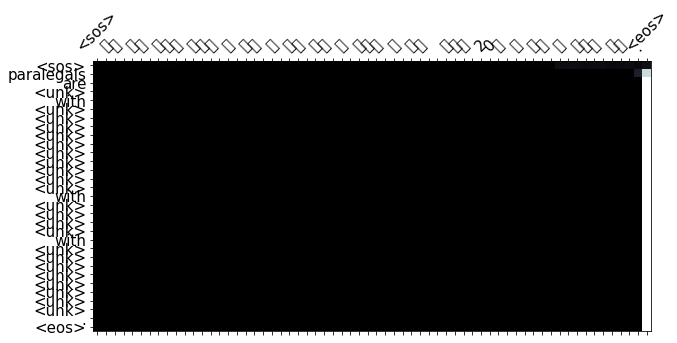

In [ ]:
# 1. Packed Padded Seq
example_idx = 4
translation, attention = translate_sentence(sen_list[example_idx], KOREAN, ENGLISH, Seq2Seq_model, device)

print(f'predicted trg = {translation}')

display_attention(sen_list[example_idx], translation, attention)

In [46]:
# Visualization
def TS_display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention[0][1], cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

predicted trg = ['sketch', 'sketch', 'geumho', 'reconfirm', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711']


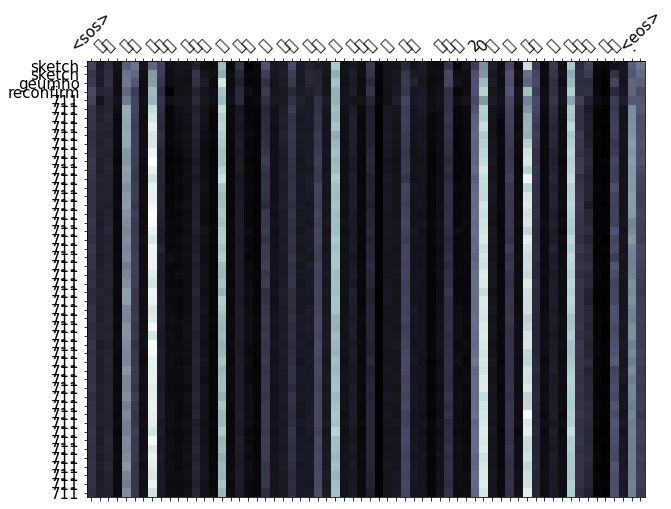

In [47]:
# 2. CNN
example_idx = 4
translation, attention = CNN_translate_sentence(sen_list[example_idx], CNN_KOREAN, CNN_ENGLISH, transformer_model, device)

print(f'predicted trg = {translation}')

TS_display_attention(sen_list[example_idx], translation, attention)

predicted trg = ['sketch', 'sketch', 'geumho', 'reconfirm', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711', '711']


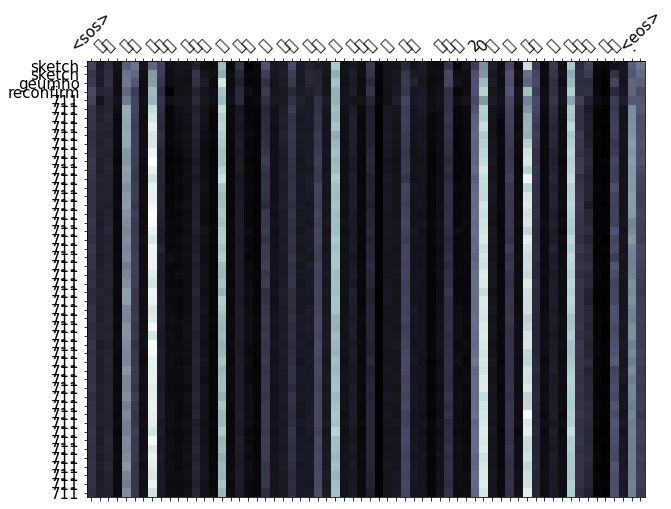

In [48]:
# 3. Transformer
example_idx = 4
translation, attention = transformer_translate_sentence(sen_list[example_idx], CNN_KOREAN, CNN_ENGLISH, transformer_model, device)

print(f'predicted trg = {translation}')

TS_display_attention(sen_list[example_idx], translation, attention)